# SCI-Paper
根据ABVS影像特征，采用多种算法比较研究，判断乳腺癌良恶性

一、准备采用的特征选择算法共７种：

参考：https://www.cnblogs.com/stevenlk/p/6543628.html

PCA : from sklearn.decomposition import PCA

LASSO-Logitic

mRMR: https://blog.csdn.net/cpc784221489/article/details/94409388

二、准备采用gridsearch来找最佳机器学习算法的最佳超参数
参考： https://blog.csdn.net/baidu_15113429/article/details/72651894

# 准备环境

In [35]:
import os,sys 
# parentdir = "/raid/huaqing/tyler/Spinal_Cord_Injury_MedAI/ICU-stay-Prediction-for-SCI-patients"
# sys.path.insert(0,parentdir)  
from ultils_for_ML_binary_classify import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [36]:
#　数据加载相关函数
def stdScal(X):
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    X = ss.fit_transform(X)
    return X


def load_and_reshape(filename,view='all'):
#     import pdb
#     pdb.set_trace()
    raw = pd.read_csv(filename,encoding='gb18030')
    raw_values = raw.values
    patient_name = raw.columns[1:-1:3]
    if view == 'all':
        # reshape feature names
        features_name = raw_values[1:,0]
        features_name = features_name.repeat(3)
        features_name = features_name.reshape([-1,3])
        view_names = ['coronal', 'transverse', 'sagittal']
        for view in range(3):
            for i,feature in enumerate(features_name[:,view]):
                features_name[i,view] = feature+'_'+view_names[view]
        features_name = features_name.reshape([-1,]).tolist()
        # reshape data
        data = raw_values[1:,1:].astype(np.float32)
        numf,numP = data.shape[0], int(data.shape[1]/3)
        
        data = data.reshape([numf,numP,3])# feature * patient * view
        data = data.transpose([1,0,2])# patient * feature * view
        data = data.reshape(numP,numf*3)# patient*(feature_new)
    elif view == 'coronal': #冠状面
        features_name = raw_values[1:,0].tolist()
        data = raw_values[1:,1::3].astype(np.float32)
        data = data.transpose([1,0])# patient * feature
    elif view == 'transverse': #横状面
        features_name = raw_values[1:,0].tolist()
        data = raw_values[1:,2::3].astype(np.float32)
        data = data.transpose([1,0])# patient * feature
    elif view == 'sagittal': #矢状面
        features_name = raw_values[1:,0].tolist()
        data = raw_values[1:,3::3].astype(np.float32)
        data = data.transpose([1,0])# patient * feature
    
    #删失数据填补
    data = uncensored(data)
    data = pd.DataFrame(data=data,columns=features_name,index=patient_name)
    return data


def uncensored(data):
    #data[np.isnan(data)]=0
    #return data
    for k in range(data.shape[1]):
        feat_data = data[:,k]
        isnan_idx = np.where(np.isnan(feat_data))
        feat_data = np.delete(feat_data,isnan_idx)
        feat_mean = feat_data.mean()
        data[isnan_idx,k] = feat_mean
    return data

from sklearn.linear_model import LogisticRegression as LR
LogR = LR(penalty='l2',dual=False,tol=0.0001,C=1.0,fit_intercept=True,
   intercept_scaling=1,class_weight=None,random_state=None,
   solver='liblinear',max_iter=100,multi_class='ovr',
   verbose=0,warm_start=False,n_jobs=1)
def data_preprocess(
        fname_benign,
        fname_malignant,
        view='sagittal'):
    X_benign = load_and_reshape(fname_benign,view=view)
    X_malignant = load_and_reshape(fname_malignant,view=view)
    X_benign.index += 'benign'
    X_malignant.index += 'maligant'
    
    X_feature_names_benign = X_benign.columns.values.tolist()
    X_feature_names_malignant = X_malignant.columns.values.tolist()
    import operator
    assert operator.eq(X_feature_names_benign,X_feature_names_malignant)
    X_feature_names = X_feature_names_benign
    
    Y_feature_names = 'maligant'
    Y_benign = pd.DataFrame(data = np.zeros((X_benign.shape[0],1)), 
                            index = X_benign.index,
                            columns = [Y_feature_names])#benign:0
    Y_malignant = pd.DataFrame(data = np.ones((X_malignant.shape[0],1)), 
                               index = X_malignant.index,
                               columns=[Y_feature_names])#malignant:1
    Y = pd.concat([Y_benign,Y_malignant], axis=0)
    #各特征取值标准化
    X = pd.concat([X_benign,X_malignant],axis=0)
    from sklearn.preprocessing import StandardScaler
    stdScaller = StandardScaler()
    Xstd = stdScaller.fit_transform(X)
    
    X = pd.DataFrame( data=Xstd, index=X.index, columns=X_feature_names )
    YX = pd.concat([Y,X],axis=1)
    
#     #　shuffle patients order
#     YX = YX.sample( frac=1.0, replace=False ) 

    return YX,stdScaller,X_feature_names,Y_feature_names

# 数据预处理

## 读取原始数据

In [37]:
dir_result = './ABVS-Paper2-Results'#结果保存路径
if not os.path.isdir(dir_result):
    os.mkdir(dir_result)

# 数据集读取和预处理
fname_benign = './data/benign.csv'
fname_malignant = './data/malignant.csv'
view = 'all' #'coronal' 'transverse'  'sagittal'
n_features_to_select = 50

# 预处理数据
YX,stdScaller,X_feature_names,Y_feature_name = data_preprocess( fname_benign, fname_malignant, view=view)#我的数据预处理

# 显示数据样本
display(YX)

,maligant,GeoX_coronal,GeoX_transverse,GeoX_sagittal,GeoY_coronal,GeoY_transverse,GeoY_sagittal,GeoF_coronal,GeoF_transverse,GeoF_sagittal,...,WavEnLL_s-7_sagittal,WavEnLH_s-7_coronal,WavEnLH_s-7_transverse,WavEnLH_s-7_sagittal,WavEnHL_s-7_coronal,WavEnHL_s-7_transverse,WavEnHL_s-7_sagittal,WavEnHH_s-7_coronal,WavEnHH_s-7_transverse,WavEnHH_s-7_sagittal
肖光惠benign,0.0,-0.234407,-0.253898,0.764307,0.732842,-0.342466,-0.277549,1.396191,2.096106,1.711826,...,0.0,0.008680,0.0,0.0,0.813951,0.0,0.0,1.042651,0.0,0.0
张丽群benign,0.0,-1.180933,-1.160880,0.980647,1.052131,-2.220931,-1.665667,-0.450131,-0.638716,-0.722401,...,0.0,-0.441870,0.0,0.0,0.961248,0.0,0.0,-0.412292,0.0,0.0
牟新燕benign,0.0,0.678796,0.664673,-1.485519,-1.511287,0.431078,0.186271,-0.413105,-0.261047,-0.628191,...,0.0,-0.886686,0.0,0.0,-0.670464,0.0,0.0,-0.970909,0.0,0.0
宋万年benign,0.0,0.141628,0.202767,0.385503,0.381866,-0.090448,0.092253,-0.570228,-0.906272,-0.917630,...,0.0,-0.886686,0.0,0.0,-0.670464,0.0,0.0,-0.970909,0.0,0.0
范应珍benign,0.0,0.895701,0.980432,0.089160,0.099172,-0.366054,-0.192374,-0.405786,-0.753327,-0.704975,...,0.0,0.097977,0.0,0.0,0.142935,0.0,0.0,1.090451,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
牟润梅maligant,1.0,-0.606564,-0.254201,-1.052907,-0.952209,-1.041678,-1.056475,2.392125,1.006128,1.809577,...,0.0,1.805956,0.0,0.0,1.634068,0.0,0.0,0.367700,0.0,0.0
詹定英maligant,1.0,0.742584,0.858366,0.688762,0.641857,0.880530,0.503499,0.976062,0.216564,0.914304,...,0.0,2.010255,0.0,0.0,0.620018,0.0,0.0,0.372216,0.0,0.0
张小群maligant,1.0,-0.230279,0.021386,-1.197055,-1.372734,1.436136,0.893144,2.634789,3.213074,2.072331,...,0.0,1.193697,0.0,0.0,-0.035577,0.0,0.0,0.626412,0.0,0.0
杨定群10点maligant,1.0,-1.309123,-1.130928,-0.253632,-0.338444,0.685535,0.536422,0.396341,0.844577,0.443795,...,0.0,0.218508,0.0,0.0,1.510579,0.0,0.0,3.142251,0.0,0.0


## 原始数据分布特性统计+预处理

,maligant,GeoX_coronal,GeoX_transverse,GeoX_sagittal,GeoY_coronal,GeoY_transverse,GeoY_sagittal,GeoF_coronal,GeoF_transverse,GeoF_sagittal,...,WavEnLL_s-7_sagittal,WavEnLH_s-7_coronal,WavEnLH_s-7_transverse,WavEnLH_s-7_sagittal,WavEnHL_s-7_coronal,WavEnHL_s-7_transverse,WavEnHL_s-7_sagittal,WavEnHH_s-7_coronal,WavEnHH_s-7_transverse,WavEnHH_s-7_sagittal
罗桂霜8点benign,0.0,-2.038572,-2.042445,0.932976,0.941745,-1.874942,-1.307727,-0.390465,-0.652211,-0.572100,...,0.0,-0.578265,0.0,0.0,3.494901,0.0,0.0,-0.203188,0.0,0.0
胡小燕左乳头benign,0.0,-0.915282,-1.005150,0.220016,0.178499,-0.685553,-0.882455,-0.452429,-0.667467,-0.780126,...,0.0,-0.886686,0.0,0.0,-0.670464,0.0,0.0,-0.970909,0.0,0.0
易蜀云benign,0.0,-0.879718,-0.887827,-0.101862,-0.098786,-0.514104,-0.461353,-0.440087,-0.694261,-0.800819,...,0.0,-0.124855,0.0,0.0,-0.218475,0.0,0.0,-0.222285,0.0,0.0
姜泽芬maligant,1.0,-0.849415,-0.830828,-0.469656,-0.382060,0.783660,0.628196,-0.044471,0.522649,1.124780,...,0.0,-0.886686,0.0,0.0,-0.670464,0.0,0.0,-0.970909,0.0,0.0
张小群maligant,1.0,-0.230279,0.021386,-1.197055,-1.372734,1.436136,0.893144,2.634789,3.213074,2.072331,...,0.0,1.193697,0.0,0.0,-0.035577,0.0,0.0,0.626412,0.0,0.0
杨定群12点benign,0.0,0.111013,0.169957,-0.382924,-0.370391,1.209042,0.854124,-0.366547,-0.654949,-0.686732,...,0.0,-0.124855,0.0,0.0,-0.218475,0.0,0.0,-0.222285,0.0,0.0
黄茂芬benign,0.0,-0.660448,-0.792426,1.558192,1.648017,-0.136909,-0.241937,-0.535586,-0.818652,-0.883049,...,0.0,-0.124855,0.0,0.0,-0.218475,0.0,0.0,-0.222285,0.0,0.0
包主芬6点benign,0.0,-0.862496,-0.722911,1.621202,1.688188,-0.515701,-0.493609,-0.403658,-0.451153,-0.632820,...,0.0,-0.124855,0.0,0.0,-0.218475,0.0,0.0,-0.222285,0.0,0.0
彭中芝maligant,1.0,-2.114376,-2.176478,0.152226,0.143497,2.655976,0.946153,-0.484602,-0.212152,-0.518460,...,0.0,1.185423,0.0,0.0,3.225259,0.0,0.0,-0.114302,0.0,0.0
王其德maligant,1.0,-1.170033,-1.039437,-0.166791,-0.175444,-1.659767,-1.584654,-0.251727,-0.504351,-0.166123,...,0.0,-0.189564,0.0,0.0,0.510347,0.0,0.0,7.866555,0.0,0.0


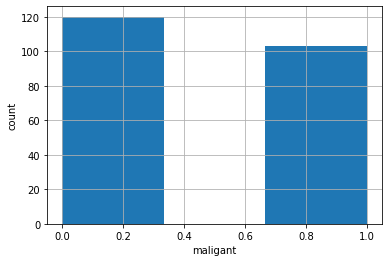

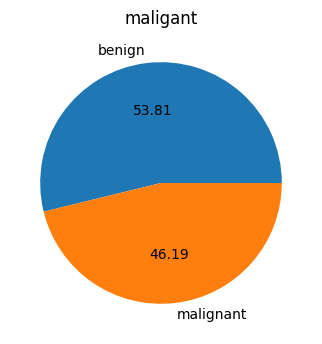

In [38]:
## 考察应变量Y的分布（hist图、中值）
# fillna# hasnans# groupby# mean
ax = YX[Y_feature_name].hist(bins=3)
ax.set_xlabel(Y_feature_name)
ax.set_ylabel('count')
fn = os.path.join(dir_result,'internal-dataset Histgram of sum_admission.png')
plt.savefig(fn)

## Y分组的饼图
df = YX[Y_feature_name].replace({0: 'benign', 1: 'malignant'},inplace=False).value_counts()
f,ax = plt.subplots(dpi=100)
df.plot.pie(figsize=(4, 4),autopct='%.2f',title=Y_feature_name)
ax.set_ylabel('')
fn = os.path.join(dir_result,'Internal Dataset Pie Chart of Dependent Variable.png')
plt.savefig(fn)

X = YX[X_feature_names]
Y = YX[Y_feature_name]

# # 划分训练集和测试集
# （１）随机划分数据集
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

processed_data={'X_train':X_train,
                'Y_train':Y_train,
                'X_test':X_test,
                'Y_test':Y_test,
                'class_names':['benign', 'malignant']
               }

#　保存预处理、切分后的数据集
fn = os.path.join(dir_result,'processed_YX_test.csv')
YX_test = pd.concat([Y_test,X_test],axis=1)
YX_test.to_csv(fn,encoding='gb18030')

fn = os.path.join(dir_result,'processed_YX_trainval.csv')
YX_train = pd.concat([Y_train,X_train],axis=1)
YX_train.to_csv(fn,encoding='gb18030')

display(YX_test)

n_repeats = 5 #P次
n_splits = 3 #K折

In [39]:
Y_test.index

Index(['罗桂霜8点benign', '胡小燕左乳头benign', '易蜀云benign', '姜泽芬maligant',
       '张小群maligant', '杨定群12点benign', '黄茂芬benign', '包主芬6点benign',
       '彭中芝maligant', '王其德maligant', '林波会benign', '王晓琴benign', '曾传英+maligant',
       '黎贤珍benign', '杨贵友1点benign', '张盛秀benign', '赵世英maligant', '胡小燕11点benign',
       '罗江美maligant', '陈秋烨3点benign', '黄正芹8点benign', '张莉benign', '胡启英benign',
       '周忠芬+maligant', '李世莲+maligant', '候正maligant', '杨志连maligant',
       '孔德容+benign', '戚长先6点benign', '张明玉乳头benign', '亢光清maligant', '刘文林benign',
       '刑高杰3点benign', '付国玲+maligant', '代小江maligant', '罗琴benign', '张群maligant',
       '温钰benign', '宋尧英benign', '李生玉3点maligant', '周忠芬maligant', '李康群maligant',
       '宋传芬maligant', '李文华maligant', '杜显英maligant'],
      dtype='object')

# 训练与验证

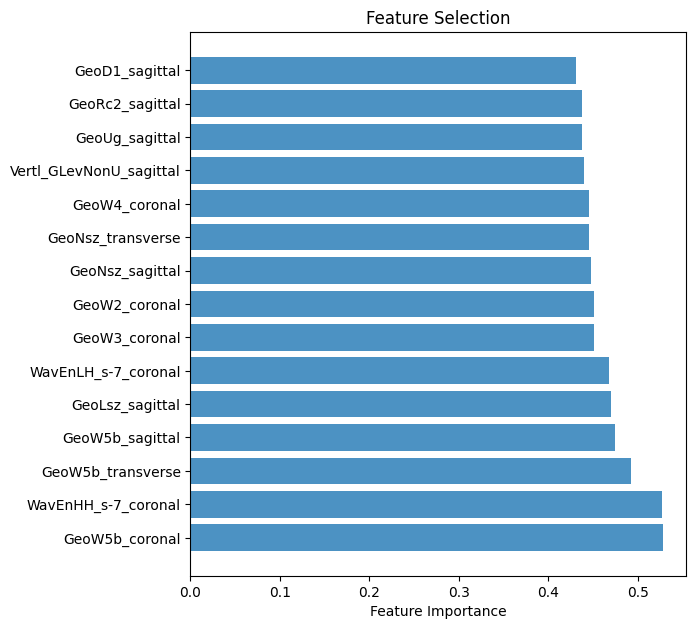

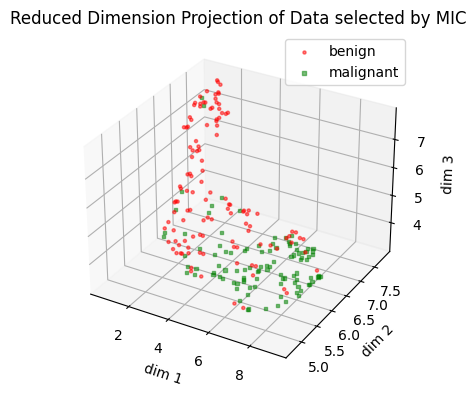

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

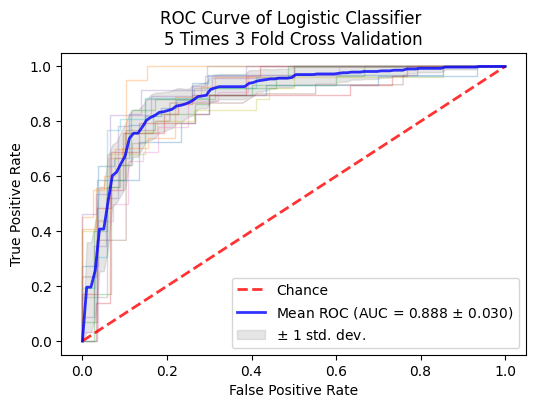

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


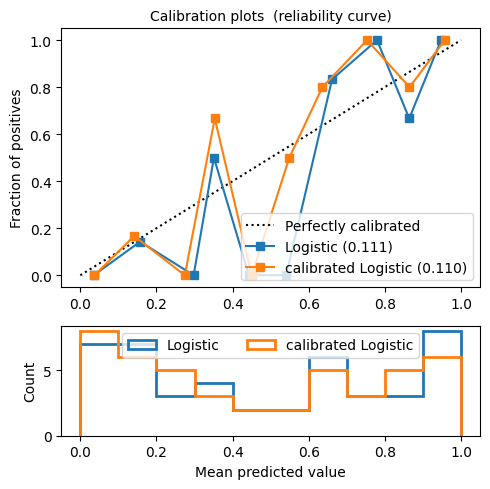

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


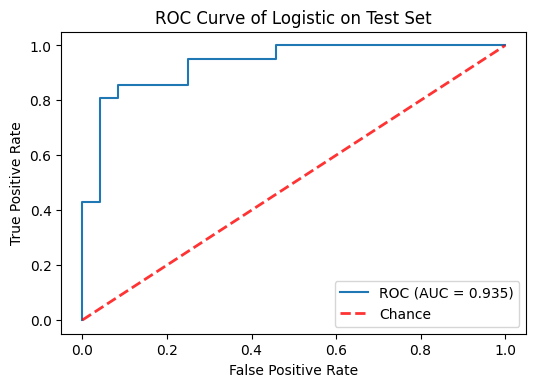

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


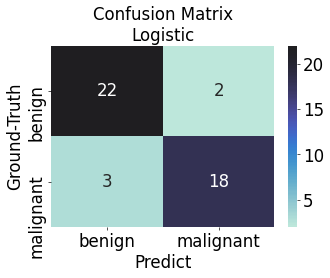

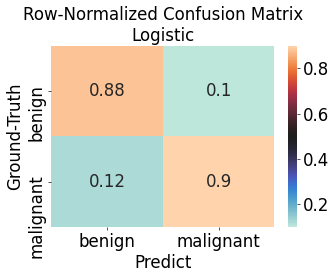

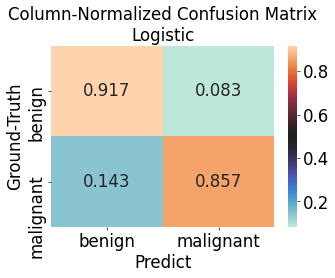

              precision    recall  f1-score   support

      benign      0.880     0.917     0.898        24
   malignant      0.900     0.857     0.878        21

    accuracy                          0.889        45
   macro avg      0.890     0.887     0.888        45
weighted avg      0.889     0.889     0.889        45

roc_auc: 0.935


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


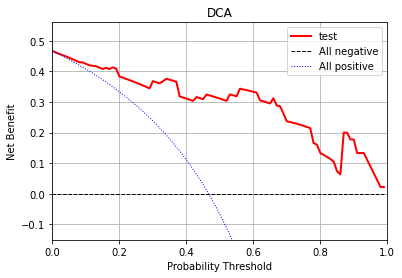

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

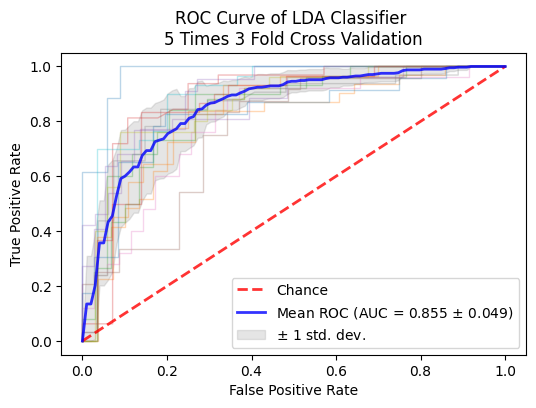

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(


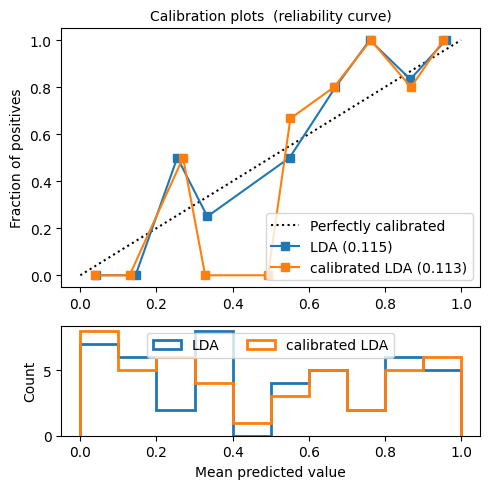

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


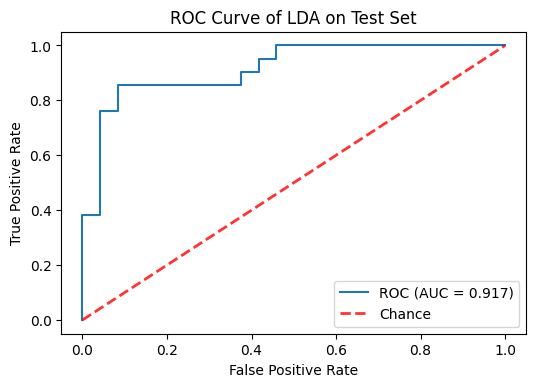

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(


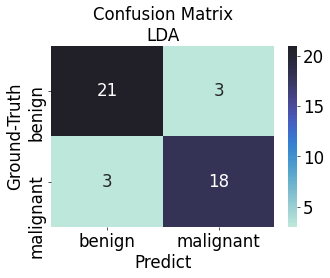

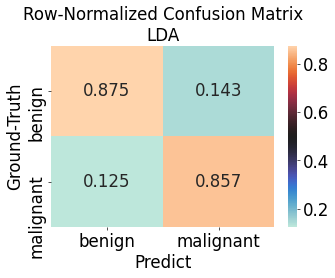

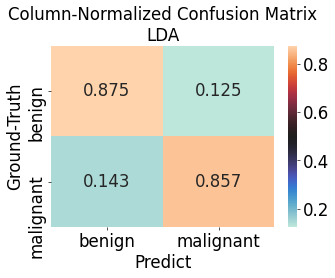

              precision    recall  f1-score   support

      benign      0.875     0.875     0.875        24
   malignant      0.857     0.857     0.857        21

    accuracy                          0.867        45
   macro avg      0.866     0.866     0.866        45
weighted avg      0.867     0.867     0.867        45

roc_auc: 0.917


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(


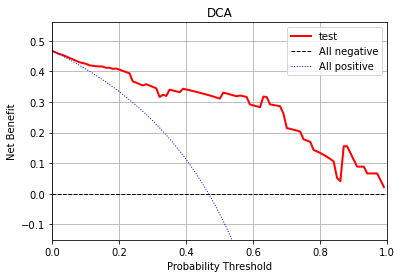

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

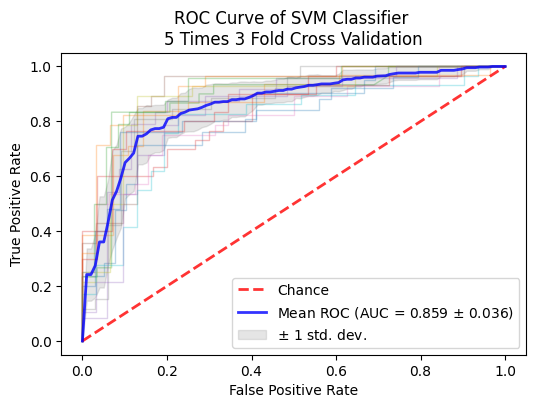

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


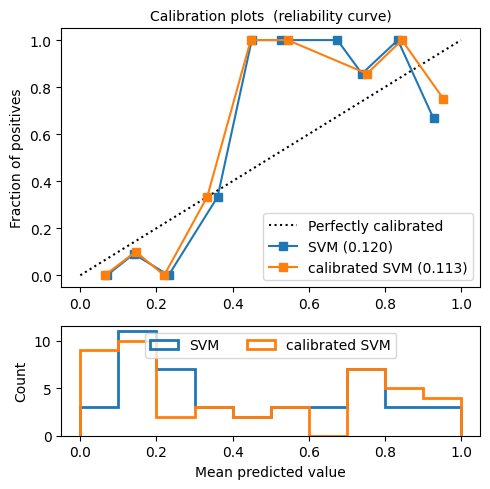

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


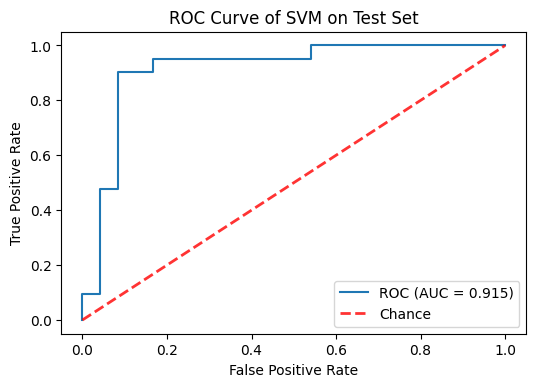

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


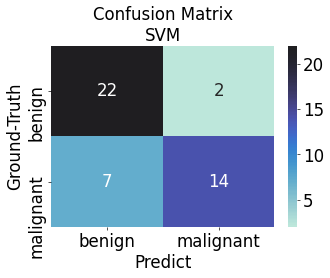

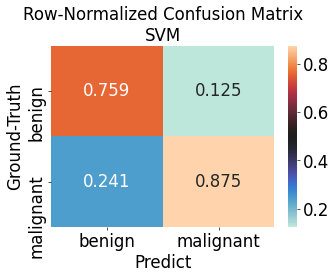

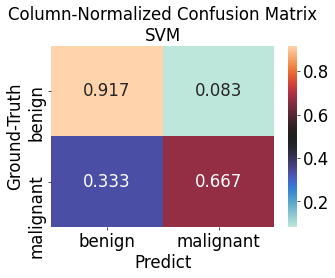

              precision    recall  f1-score   support

      benign      0.759     0.917     0.830        24
   malignant      0.875     0.667     0.757        21

    accuracy                          0.800        45
   macro avg      0.817     0.792     0.793        45
weighted avg      0.813     0.800     0.796        45

roc_auc: 0.915


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


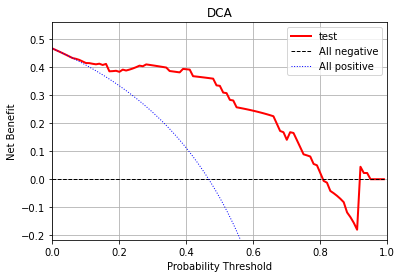

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

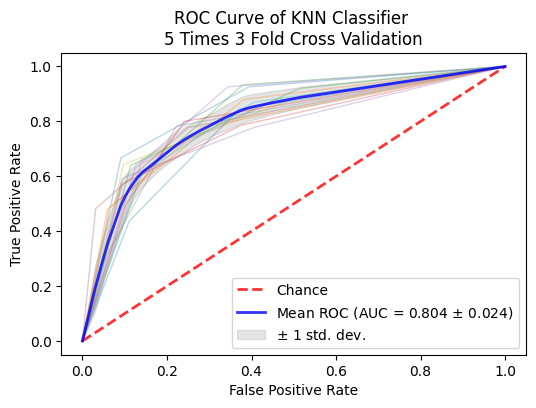

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


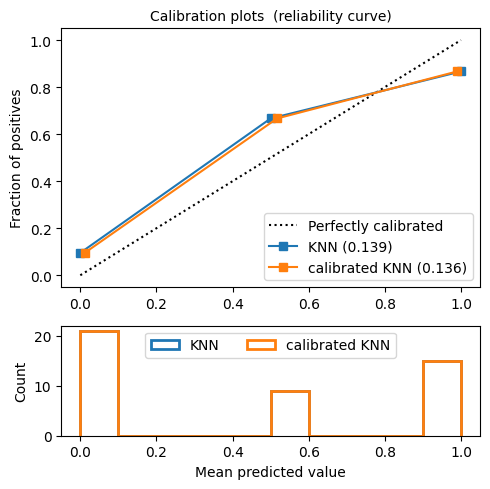

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


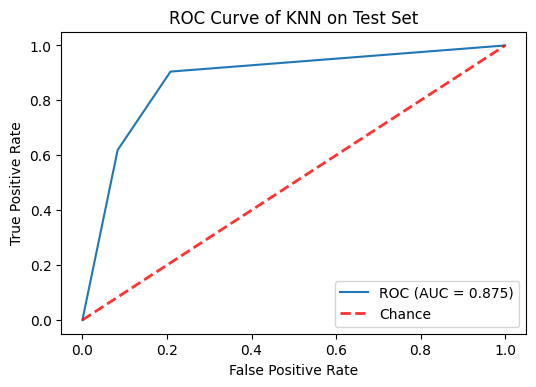

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


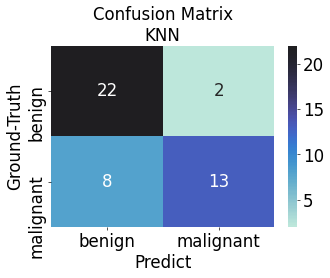

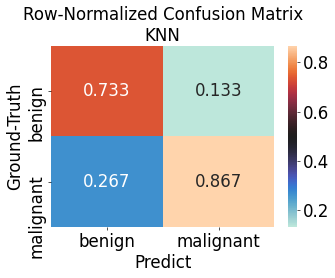

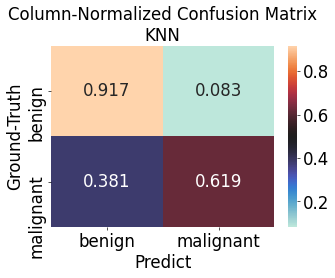

              precision    recall  f1-score   support

      benign      0.733     0.917     0.815        24
   malignant      0.867     0.619     0.722        21

    accuracy                          0.778        45
   macro avg      0.800     0.768     0.769        45
weighted avg      0.796     0.778     0.772        45

roc_auc: 0.875


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


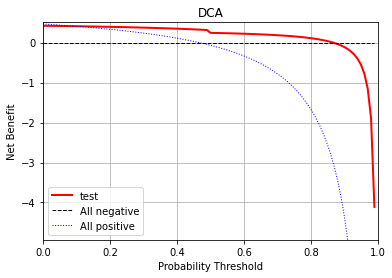

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

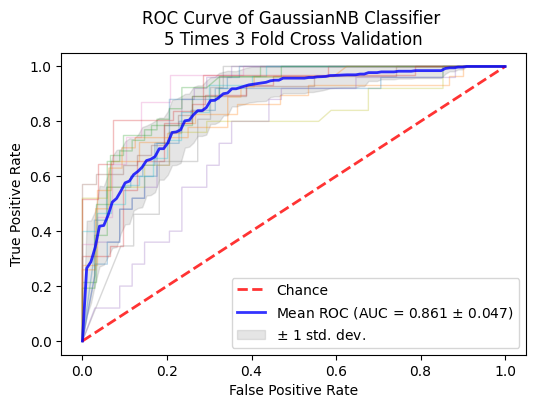

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


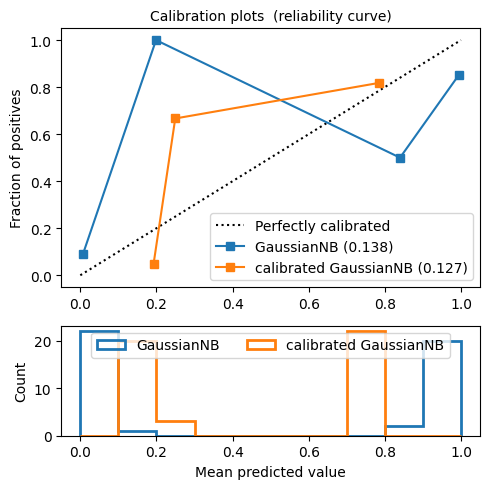

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


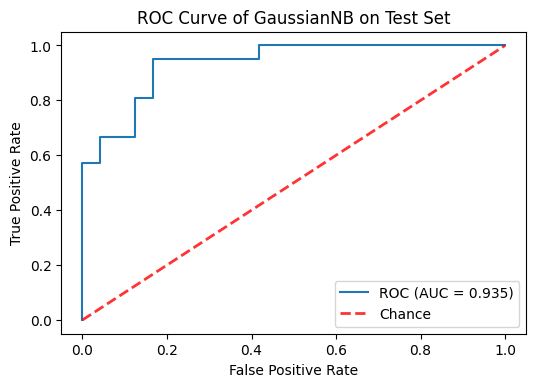

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


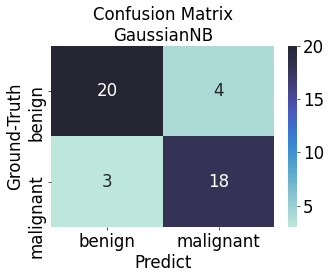

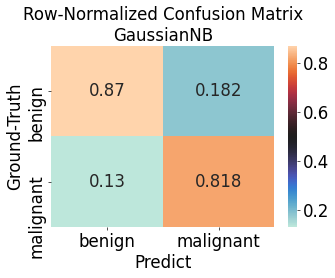

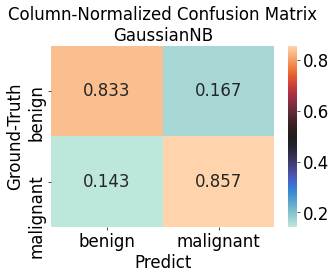

              precision    recall  f1-score   support

      benign      0.870     0.833     0.851        24
   malignant      0.818     0.857     0.837        21

    accuracy                          0.844        45
   macro avg      0.844     0.845     0.844        45
weighted avg      0.846     0.844     0.845        45

roc_auc: 0.935


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


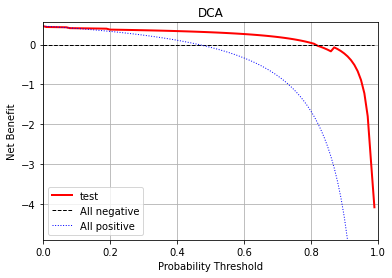

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

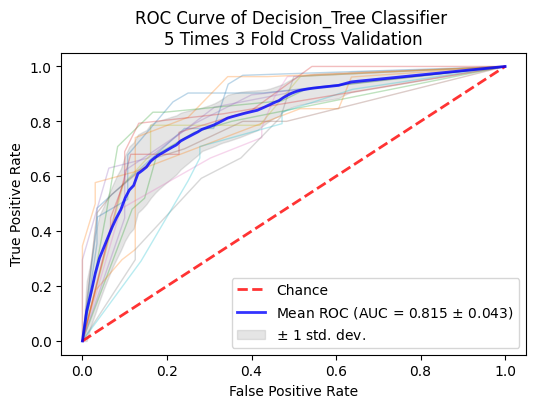

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


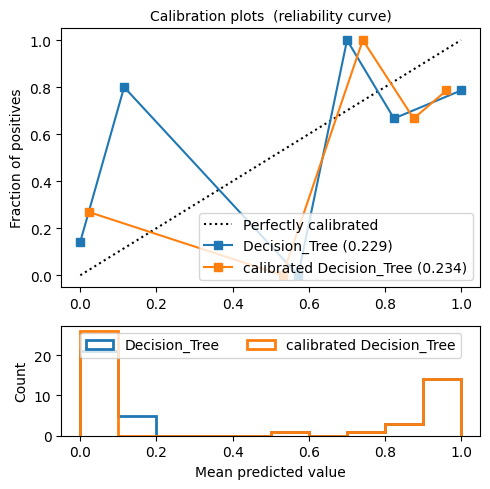

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


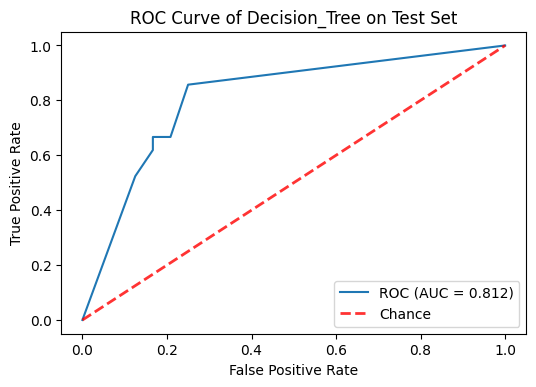

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


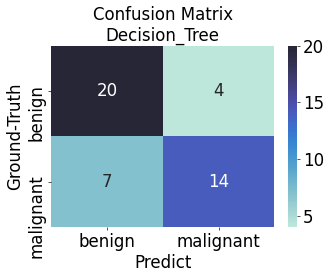

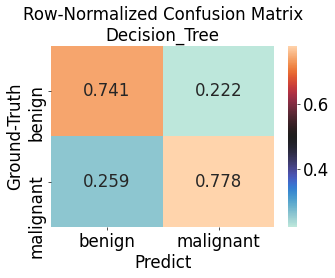

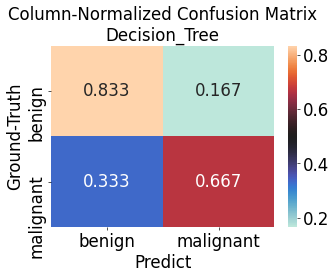

              precision    recall  f1-score   support

      benign      0.741     0.833     0.784        24
   malignant      0.778     0.667     0.718        21

    accuracy                          0.756        45
   macro avg      0.759     0.750     0.751        45
weighted avg      0.758     0.756     0.753        45

roc_auc: 0.812


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


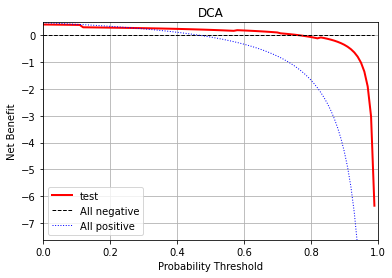

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

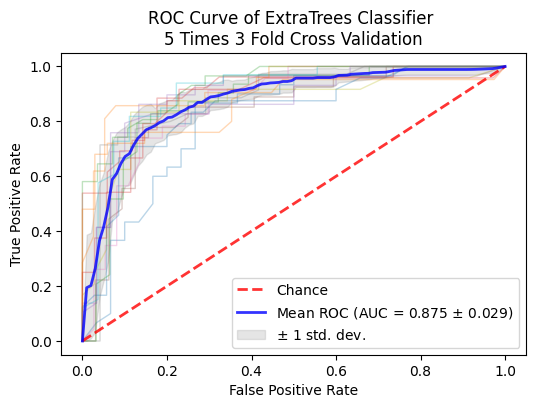

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


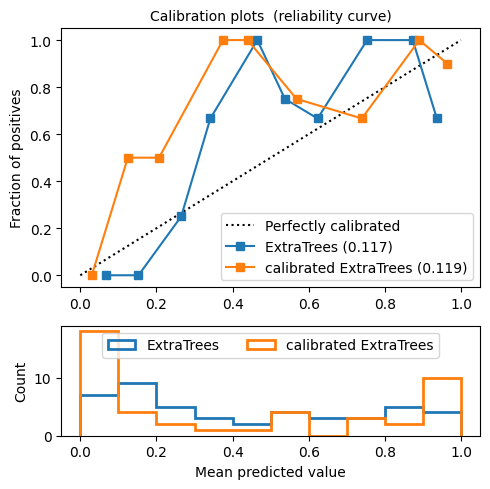

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


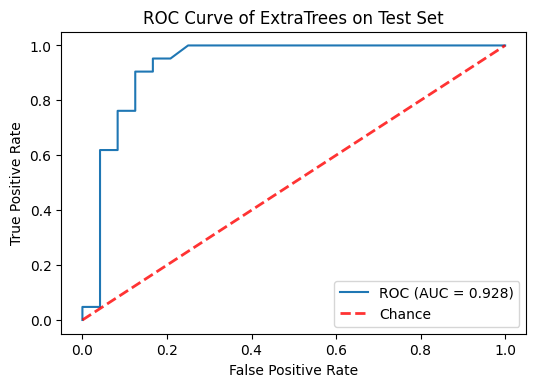

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


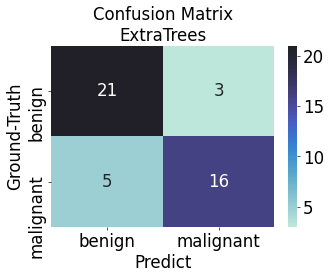

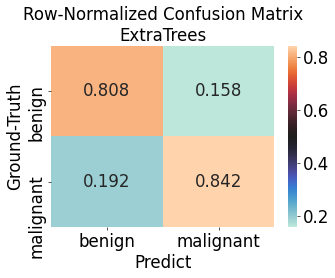

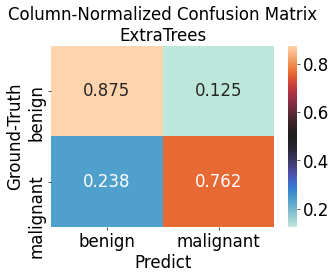

              precision    recall  f1-score   support

      benign      0.808     0.875     0.840        24
   malignant      0.842     0.762     0.800        21

    accuracy                          0.822        45
   macro avg      0.825     0.818     0.820        45
weighted avg      0.824     0.822     0.821        45

roc_auc: 0.928


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreesClassifier was fitted without feature names
  warnings.warn(


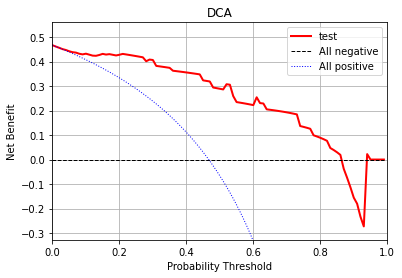

TypeError: __init__() got an unexpected keyword argument 'min_impurity_split'

In [40]:
#构建特征选择×分类算法组合AUC矩阵
feature_select_method = ['MIC','RFE','EmbeddingLSVC','EmbeddingLR','EmbeddingTree','EmbeddingRF','mRMR']
all_name_selected_features = dict()
for k,method in enumerate(feature_select_method):
    dir_result_method = os.path.join(dir_result,method)
    if not os.path.isdir(dir_result_method):
        os.mkdir(dir_result_method)

    aucs_RepeatedKFold_df,aucs_testset_df,aucs_external_df,best_clf_objects_df,name_selected_features = run_algorithms(
        processed_data,
        data_external=None,
        feature_select_method=method,
        kbest = 25,
        n_splits=n_splits,n_repeats=n_repeats,
        best_threshold = True,
        dir_result=dir_result_method)
    
    mean_aucs = aucs_RepeatedKFold_df.mean(axis='columns')
    mean_aucs = pd.DataFrame(data=mean_aucs.values[:,np.newaxis],
                             index=mean_aucs.index,
                             columns=[method])
    
    best_clfs_col = pd.DataFrame(best_clf_objects_df['best_clf'].values,
                                 index=best_clf_objects_df.index,
                                 columns=[method] )                             
    
    #选择出来的特征的名称列表
    all_name_selected_features[method] = name_selected_features
    if k==0:
        mean_aucs_matrix = mean_aucs.copy()
        aucs_testset_matrix = aucs_testset_df.copy()
        aucs_external_matrix = aucs_external_df.copy() if aucs_external_df else None
        best_clfs_matrix = best_clfs_col.copy()
    else:
        mean_aucs_matrix = pd.concat([mean_aucs_matrix,mean_aucs],axis=1)
        aucs_testset_matrix = pd.concat([aucs_testset_matrix,aucs_testset_df],axis=1)
        if aucs_external_df and aucs_external_matrix:
            aucs_external_matrix = pd.concat([aucs_external_matrix,aucs_external_df],axis=1) 
        else:
            ucs_external_matrix = None
        best_clfs_matrix = pd.concat([best_clfs_matrix,best_clfs_col],axis=1)

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# LDA_clf = LinearDiscriminantAnalysis(solver='eigen', covariance_estimator=OAS() )
LinearDiscriminantAnalysis()

LinearDiscriminantAnalysis()

In [ ]:
# 画图
def plot_mean_aucs_matirx(mean_aucs_matrix, fmt='.3g',center=0.5,
                          title='mean AUC Matrix',
                          fn='mean AUC Matrix.png'
                         ):
    """画平均auc矩阵：横轴是机器学习分类算法，纵轴是特征选择算法，格子内的数值是mean_auc"""

    cm = mean_aucs_matrix.values
    algorithms = mean_aucs_matrix.columns.tolist()
    feature_selection_methods = mean_aucs_matrix.index.tolist()
    
    f,ax = plt.subplots(dpi=100)
    ax = sns.heatmap(cm,annot=True,fmt=fmt,center=center,annot_kws={'size':6,'ha':'center','va':'center'})
    ax.set_title(title,fontsize=10)#图片标题文本和字体大小
    ax.set_xlabel('Classifier',fontsize=10)#x轴label的文本和字体大小
    ax.set_ylabel('Feature Selection Method',fontsize=10)#y轴label的文本和字体大小
    ax.set_xticklabels(algorithms,fontsize=10, rotation='vertical')#x轴刻度的文本和字体大小
#     plt.xticks([y+1 for y in range(len(x))], x_names, rotation='vertical')
    ax.set_yticklabels(feature_selection_methods,fontsize=10, rotation='horizontal')#y轴刻度的文本和字体大小
    #设置colorbar的刻度字体大小
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=10)
    
    plt.savefig(fn, bbox_inches='tight')
    plt.show()
    return f,ax


#　交叉验证的AUC矩阵
plot_mean_aucs_matirx(mean_aucs_matrix.T, fmt='.3g',
                      title='Mean AUC Matrix',
                      fn=os.path.join(dir_result,'mean AUC Matrix on Train Set RepeatedKFold Cross Validation.png'))
#　内部测试集的AUC矩阵
plot_mean_aucs_matirx(aucs_testset_matrix.T, fmt='.3g',
                      title='AUC Matrix on Test-set',
                      fn=os.path.join(dir_result,'AUC Matrix on Test Set.png'))
#　外部测试集的AUC矩阵
if aucs_external_matrix:
    plot_mean_aucs_matirx(aucs_external_matrix.T, fmt='.3g',
                          title='AUC Matrix on External Data-set',
                          fn=os.path.join(dir_result,'AUC Matrix on External Data-set.png'))

# 先保存以上变量

In [ ]:
result_vars = dict(
    processed_data = processed_data,
    mean_aucs_matrix = mean_aucs_matrix,
    aucs_testset_matrix = aucs_testset_matrix,
    all_name_selected_features = all_name_selected_features,
)
final_allsave_filename = os.path.join(dir_result,'all_python_vars.npy')
np.save(final_allsave_filename,
        result_vars, 
        allow_pickle=True
       )

## 选出最佳特征选择方法，并在该特征组合下，集成最佳的几个分类器
VotingClassifier / StackingClassifier

In [ ]:
best_clfs_matrix

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
kbest = 3

best_clfs_matrix_noDNN = best_clfs_matrix.iloc[0:-1]

mean_aucs_matrix_stack = mean_aucs_matrix.stack()
best_alg_comb = mean_aucs_matrix_stack.nlargest(kbest)#panda series
fn = os.path.join(dir_result,'StackingClassifier','topN_Algorithm_Combination.csv')
best_alg_comb.to_csv(fn)
display(best_alg_comb)

best_clf = np.zeros([kbest]).tolist()
pipeline = np.zeros([kbest]).tolist()
for k in range(kbest):
    clf_name = best_alg_comb.index[k][0]
    feature_selector_name = best_alg_comb.index[k][1]
    best_clf[k] = best_clfs_matrix_noDNN.loc[ clf_name ][ feature_selector_name ]
    
    selected_features = all_name_selected_features[feature_selector_name]#特征名称列表
    selector = DataFrameSelector(selected_features)

    pipeline[k] = (clf_name+'_'+feature_selector_name,
                   Pipeline( [('selector',selector),('clf',best_clf[k])] )
                  )
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
Stacking_clf = StackingClassifier(estimators=pipeline)#, final_estimator=LogisticRegression)

# 获取特征选择后的数据
X_train = processed_data['X_train']#.values#dataframe
X_test = processed_data['X_test']#.values#dataframe
Y_train = processed_data['Y_train'].values
Y_test = processed_data['Y_test'].values
X_external,Y_external = None,None
class_names = processed_data['class_names']
# 运行交叉验证、内部数据集测试、外部数据集测试
ret_ensembest_clf = get_algorithm_result(X_train,Y_train,X_test,Y_test,
                                         X_external,Y_external,
                                         class_names,
                                         n_splits,n_repeats,
                                         classifier=Stacking_clf,#Voting_clf, 
                                         clf_name='StackingClassifier',#'StackingClassifier',#'VotingClassifier',
                                         dir_result=dir_result)

## 特征重要性排序

In [ ]:
# 排序重要性
import eli5
from eli5.sklearn import PermutationImportance

X_train_select = X_train[all_name_selected_features[feature_selector_name]]
X_test_select = X_test[all_name_selected_features[feature_selector_name]]

Stacking_clf_fitted = Stacking_clf.fit(X_train_select,Y_train)
perm = PermutationImportance(Stacking_clf_fitted, random_state=2020).fit(X_test_select,Y_test)
eli5.show_weights(perm, feature_names = X_test_select.columns.tolist(), top=None)

# 画图
fig = plt.figure(dpi=100,figsize=(6,10))
feat_imp = pd.DataFrame(data=perm.feature_importances_,
                        index=X_test_select.columns.tolist(),
                        columns=['feature importance'])
feat_imp.sort_values(by=['feature importance'],axis='index', ascending=False,inplace=True)
y_pos = np.arange(feat_imp.shape[0])
plt.barh(y_pos, feat_imp.values.squeeze(), align='center', alpha=0.8)
plt.yticks(y_pos, feat_imp.index.values)
plt.xlabel("Feature Permutation Importance")
plt.ylabel("Features")
plt.tight_layout()
fn = os.path.join(dir_result,'StackingClassifier','Feature Permutation Importance.png')
plt.savefig(fn, bbox_inches='tight')
plt.show()

## 保存以上重要的变量

In [ ]:
result_vars = dict(
    processed_data = processed_data,
    mean_aucs_matrix = mean_aucs_matrix,
    aucs_testset_matrix = aucs_testset_matrix,
    all_name_selected_features = all_name_selected_features,
    best_clfs_matrix_noDNN = best_clfs_matrix_noDNN, 
    best_alg_comb = best_alg_comb,
    Stacking_clf = Stacking_clf, 
    ret_ensembest_clf = ret_ensembest_clf
)
final_allsave_filename = os.path.join(dir_result,'all_python_vars.npy')
np.save(final_allsave_filename,
        result_vars, 
        allow_pickle=True
       )

In [ ]:
# import os
# import numpy as np

# final_allsave_filename = os.path.join(dir_result,'all_python_vars.npy')
# all_var = np.load(final_allsave_filename,allow_pickle=True)
# processed_data = all_var.item()['processed_data']
# mean_aucs_matrix = all_var.item()['mean_aucs_matrix']
# aucs_testset_matrix = all_var.item()['aucs_testset_matrix']
# all_name_selected_features = all_var.item()['all_name_selected_features']
# best_clfs_matrix_noDNN = all_var.item()['best_clfs_matrix_noDNN']
# best_alg_comb = all_var.item()['best_alg_comb']
# Stacking_clf = all_var.item()['Stacking_clf']
# ret_ensembest_clf = all_var.item()['ret_ensembest_clf']
# # 获取特征选择后的数据
# X_train = processed_data['X_train']#.values#dataframe
# X_test = processed_data['X_test']#.values#dataframe
# Y_train = processed_data['Y_train'].values
# Y_test = processed_data['Y_test'].values
# X_external,Y_external = None,None
# class_names = processed_data['class_names']

# 人机对抗实验

## 导入机器学习的结果

In [23]:
# result_vars = dict(
#     processed_data = processed_data,
#     mean_aucs_matrix = mean_aucs_matrix,
#     aucs_testset_matrix = aucs_testset_matrix,
#     all_name_selected_features = all_name_selected_features,
#     best_clfs_matrix_noDNN = best_clfs_matrix_noDNN, 
#     best_alg_comb = best_alg_comb,
#     Stacking_clf = Stacking_clf, 
#     ret_ensembest_clf = ret_ensembest_clf
# )

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
final_allsave_filename = os.path.join(dir_result,'all_python_vars.npy')
result_vars = np.load(final_allsave_filename, allow_pickle=True)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StackingClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own 

## 统计医生的specifity\sensitivity\f1-score\accuracy\precision

In [15]:
class_names = processed_data['class_names']

In [16]:
fn = 'data/processed_YX_test_reader123.csv'
raw = pd.read_csv(fn,encoding='gb18030')
reader_colnames = ['reader 1H.1', 'reader 2C.1', 'reader 3Y.1']

## 1)计算
Y_test = raw['maligant']
from sklearn.metrics import classification_report
report_text = ''
for reader in reader_colnames:
    y_pred = raw[reader]>0.5
    report = classification_report(
        y_true=Y_test, 
        y_pred=y_pred, 
        labels=np.unique(Y_test).tolist(),
        target_names=class_names,
        digits=3,
        output_dict=False
    )
    report_text += '\n'+reader[:-3]+':\n'+report+'\n'
print(report_text)
## 2)保存
fn = os.path.join(dir_result,'Human Experiment Report.txt')
save_text(fn, report_text)


reader 1:
              precision    recall  f1-score   support

      benign      1.000     0.458     0.629        24
   malignant      0.618     1.000     0.764        21

    accuracy                          0.711        45
   macro avg      0.809     0.729     0.696        45
weighted avg      0.822     0.711     0.692        45


reader 2:
              precision    recall  f1-score   support

      benign      0.941     0.667     0.780        24
   malignant      0.714     0.952     0.816        21

    accuracy                          0.800        45
   macro avg      0.828     0.810     0.798        45
weighted avg      0.835     0.800     0.797        45


reader 3:
              precision    recall  f1-score   support

      benign      0.870     0.833     0.851        24
   malignant      0.818     0.857     0.837        21

    accuracy                          0.844        45
   macro avg      0.844     0.845     0.844        45
weighted avg      0.846     0.844     0.8

## roc曲线图

In [17]:
from sklearn.metrics import plot_roc_curve as plot_roc_curve_V0
kbest = 5

best_clfs_matrix_noDNN = best_clfs_matrix.iloc[0:-1]

mean_aucs_matrix_stack = mean_aucs_matrix.iloc[0:-1].stack()
best_alg_comb = mean_aucs_matrix_stack.nlargest(kbest)#panda series
fn = os.path.join(dir_result,'StackingClassifier','topN_Algorithm_Combination.csv')
best_alg_comb.to_csv(fn)
display(best_alg_comb)

fig, ax = plt.subplots(dpi=100)
legend = []
best_clf = np.zeros([kbest]).tolist()
pipeline = np.zeros([kbest]).tolist()
# 1)ML
for k in range(kbest):
    clf_name = best_alg_comb.index[k][0]
    feature_selector_name = best_alg_comb.index[k][1]
    best_clf[k] = best_clfs_matrix_noDNN.loc[ clf_name ][ feature_selector_name ]
    
    selected_features = all_name_selected_features[feature_selector_name]#特征名称列表
    selector = DataFrameSelector(selected_features)

    pipeline[k] = Pipeline( [('selector',selector),('clf',best_clf[k])] )
    
    classifier_fitted =  pipeline[k].fit(X_train, Y_train)
    ##　测试集上的ROC曲线及其AUC
    alg_name = clf_name+'-'+feature_selector_name
    viz = plot_roc_curve(classifier_fitted, X_test, Y_test,
                         label=alg_name,    
                         name=alg_name,
                         ax=ax)
    roc_auc = viz.roc_auc
    legend.append( alg_name+' ROC (AUC = %0.3f)' % (roc_auc) ) 
## 4)DNN
from modelsV5 import dnn
selected_features = all_name_selected_features['RFE']
X_train_DNN = X_train[selected_features]
X_test_DNN = X_test[selected_features]
DNN_model = best_clfs_matrix.loc['DNN']['RFE']
DNN_model.train(
    X_train_DNN, Y_train,
    X_test_DNN, Y_test,
    num_epoch=2000,
    plot_loss_curve=False, 
    plot_auc_curve=False)
viz_test = DNN_model.plot_roc_curve(
    X_test_DNN, Y_test,
    alpha=1, lw=2,
    ax=ax)
roc_auc = viz_test.roc_auc
legend.append( 'DNN'+' ROC (AUC = %0.3f)' % (roc_auc) )
        
## 3)医生
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, RocCurveDisplay
for reader in reader_colnames:
    y_pred = raw[reader]
    fpr, tpr, threshold = roc_curve(Y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    viz = RocCurveDisplay( fpr=fpr, tpr=tpr, roc_auc=roc_auc )
    viz.plot(ax=ax)
    legend.append( reader[:-3]+' ROC (AUC = %0.3f)' % (roc_auc) ) 

title='ROC Curve of Human v.s ML'+' against Test Set.png'
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
legend.append('Chance')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=title)
ax.legend(legend,fontsize=8)
fn =  os.path.join(dir_result,title.replace('\n','_'))    
plt.savefig( fn )
plt.show()

NameError: name 'best_clfs_matrix' is not defined

## delong检验

In [2]:
#　先构建dataframe保存y_pred
alg_names = [best_alg_comb.index[k][0]+"_"+best_alg_comb.index[k][1] for k in range(kbest)]
alg_names += ['DNN_RFE']
alg_names += [reader[:-3] for reader in reader_colnames]
y_pred_df = pd.DataFrame(columns=['groundtruth']+alg_names)

y_pred_df['groundtruth'] = Y_test
for clf_fitted,clf_name in zip(pipeline,alg_names[:kbest]):
    y_pred = clf_fitted.predict_proba(X_test)[:,1]
    y_pred_df[clf_name] = y_pred
y_pred_df['DNN_RFE'] = DNN_model.predict_proba(X_test_DNN)
for clf_name, reader_colname in zip(alg_names[kbest+1:],reader_colnames):   
    y_pred_df[clf_name] = raw[reader_colname].values

from delong import *

y_true = Y_test
p_value_df = pd.DataFrame(index=alg_names, columns=alg_names)
for k,clf_1_name in enumerate(alg_names):
    print(clf_1_name,":")
    y_pred_1 = y_pred_df[clf_1_name]
    for clf_2_name in alg_names[k+1:]:
        y_pred_2 = y_pred_df[clf_2_name]
        pvalue = delong_roc_test(y_true,y_pred_1,y_pred_2)[0][0]
        p_value_df.loc[clf_1_name][clf_2_name]= pvalue
        print(pvalue)

        
fn = os.path.join(dir_result,'Delong Test p-values of top6 ML and Human Reader ROC Curves.csv')
p_value_df.to_csv(fn,encoding='gb18030')
display(p_value_df)

# 保存y_pred_dict到csv
fn = os.path.join(dir_result,'y_pred of Top6 ML and Human Readers for Delong Test.csv')    
y_pred_df.to_csv(fn)
display(y_pred_df)

NameError: name 'kbest' is not defined

## 配对卡方（McNemar）检验(Top6 ML和3位医生)

In [18]:
dir_result = './ABVS-Paper2-Results'
fn = os.path.join(dir_result,'y_pred of Top6 ML and Human Readers for Delong Test.csv')
raw_pred = pd.read_csv(fn,index_col=0)

params_McN = {
    'colname_label': 'groundtruth',
    'colname_clfs': ['AdaBoost_REF','Logistic_REF','LDA_REF','Bagging_REF','SVM_REF','DNN_RFE','reader 1','reader 2','reader 3'],
    
}

# 新建一个dataframe，用来保存McN检验的p值结果
result_McN = pd.DataFrame(columns=params_McN['colname_clfs'],index=params_McN['colname_clfs'])

y_true = raw_pred[params_McN['colname_label']].values
for clf0 in params_McN['colname_clfs']:
    y_pred0 = (raw_pred[clf0].values>0.5).astype(int)
    for clf1 in params_McN['colname_clfs']:
        if clf0 == clf1:
            continue
        y_pred1 = (raw_pred[clf1].values>0.5).astype(int)
        obs = np.zeros((2,2))
        obs[0,0] = sum( (y_true==y_pred0)*(y_true==y_pred1) )
        obs[1,1] = sum( (y_true!=y_pred0)*(y_true!=y_pred1) )
        obs[0,1] = sum( (y_true==y_pred0)*(y_true!=y_pred1) )
        obs[1,0] = sum( (y_true!=y_pred0)*(y_true==y_pred1) )
#         print('======= %s v.s %s========:'%(clf0,clf1))
#         print(obs)
        from statsmodels.sandbox.stats.runs import cochrans_q, mcnemar
        statistic, pVal = mcnemar(obs,exact=False,correction=True)
#         print( "statistic = %f, pVal = %f"%(statistic, pVal) )
        result_McN.loc[clf0,clf1] = pVal
display(result_McN)
fn = os.path.join(dir_result,'McNemar test between Top6 ML and Human Readers.csv')    
result_McN.to_csv(fn)

/usr/local/lib/python3.8/dist-packages/statsmodels/sandbox/stats/runs.py:558: RuntimeWarning: divide by zero encountered in double_scalars
  stat = (np.abs(n1 - n2) - corr)**2 / (1. * (n1 + n2))


,AdaBoost_REF,Logistic_REF,LDA_REF,Bagging_REF,SVM_REF,DNN_RFE,reader 1,reader 2,reader 3
AdaBoost_REF,NaN,0.617075,0.617075,0.617075,0.617075,0.371093,0.2278,1.0,1.0
Logistic_REF,0.617075,NaN,0.0,0.0,0.0,1.0,0.07044,0.504985,1.0
LDA_REF,0.617075,0.0,NaN,0.0,0.0,1.0,0.07044,0.504985,1.0
Bagging_REF,0.617075,0.0,0.0,NaN,0.0,1.0,0.07044,0.504985,1.0
SVM_REF,0.617075,0.0,0.0,0.0,NaN,1.0,0.07044,0.504985,1.0
DNN_RFE,0.371093,1.0,1.0,1.0,1.0,NaN,0.043308,0.342782,0.77283
reader 1,0.2278,0.07044,0.07044,0.07044,0.07044,0.043308,NaN,0.422678,0.2113
reader 2,1.0,0.504985,0.504985,0.504985,0.504985,0.342782,0.422678,NaN,0.723674
reader 3,1.0,1.0,1.0,1.0,1.0,0.77283,0.2113,0.723674,NaN


In [19]:
fn

'./ABVS-Paper2-Results/McNemar test between Top6 ML and Human Readers.csv'

## 医生的指标

In [29]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


In [31]:
dir_result = './ABVS-Paper2-Results'
fn = os.path.join(dir_result,'y_pred of Top6 ML and Human Readers for Delong Test.csv')
raw_pred = pd.read_csv(fn,index_col=0)

params_McN = {
    'colname_label': 'groundtruth',
    'colname_clfs': ['reader 1','reader 2','reader 3'],
    
}
y_true = raw_pred[params_McN['colname_label']].values
for clf0 in params_McN['colname_clfs']:
    y_proba = raw_pred[clf0].values
    y_pred = (y_proba>0.5).astype(int)
    auc = roc_auc_score(y_true=y_true,y_score=y_proba)
    print( '%s:\n'%clf0 )
    print( 'auc = %f\n'%auc )
    print( 'confusion matrix:\n',confusion_matrix(y_true=y_true,y_pred=y_pred) )
    print( classification_report(y_true=y_true,y_pred=y_pred) )
    

reader 1:

auc = 0.775794

confusion matrix:
 [[11 13]
 [ 0 21]]
              precision    recall  f1-score   support

           0       1.00      0.46      0.63        24
           1       0.62      1.00      0.76        21

    accuracy                           0.71        45
   macro avg       0.81      0.73      0.70        45
weighted avg       0.82      0.71      0.69        45

reader 2:

auc = 0.916667

confusion matrix:
 [[16  8]
 [ 1 20]]
              precision    recall  f1-score   support

           0       0.94      0.67      0.78        24
           1       0.71      0.95      0.82        21

    accuracy                           0.80        45
   macro avg       0.83      0.81      0.80        45
weighted avg       0.84      0.80      0.80        45

reader 3:

auc = 0.927579

confusion matrix:
 [[20  4]
 [ 3 18]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        24
           1       0.82      0.86      0.8